In [239]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re

sns.set(style="darkgrid")
sns.set_palette('hls', 4)

# Help functions

In [240]:
def count_stats(key, arr):
    s = {}
    s['mean'] = arr[key].mean()
    s['median'] = arr[key].median()
    s['range'] = arr[key].max() - arr[key].min()
    s['var'] = arr[key].var()
    s['max'] = arr[key].max()
    s['min'] = arr[key].min()
    s['std'] = arr[key].std()
    # s['quantile'] = arr[key].quantile([0.25, 0.5, 0.75]).to_list()  # Convert quantiles to a list for easier tabular display
    return s

In [241]:
def extract_memory_value(memory_str):
    try:
        return float(memory_str.split()[0])
    except (ValueError, IndexError):
        return None

In [242]:
real_resolutions = {
    'PC_A_WIN10_Brave': [2048, 1042],
    'PC_A_WIN10_Chrome': [2048, 1035],
    'PC_A_WIN10_Firefox': [2048, 1037],
    'PC_A_WIN10_Tor': [2400, 1000],
    'PC_A_Ubuntu_Brave': [2490, 1332],
    'PC_A_Ubuntu_Firefox': [2490, 1328],
    'PC_A_Ubuntu_Chrome': [2490, 1328],
    'PC_A_Ubuntu_Tor': [2400, 1000],
    'PC_B_WIN11_Brave': [1536, 735],
    'PC_B_WIN11_Chrome': [1536, 730],
    'PC_B_WIN11_Firefox': [1536, 731],
    'PC_B_WIN11_Tor': [1400, 800],
    'PC_C_MacOS_Brave': [1512, 862],
    'PC_C_MacOS_Chrome': [1512, 858],
    'PC_C_MacOS_Firefox': [1512, 860],
    'PC_C_MacOS_Safari': [1512, 893],
    'PC_C_MacOS_Tor': [1400, 800],
}

def load_df(file_path):
    df = pd.read_csv(file_path)

    df['Attributes'] = df['Attributes'].apply(ast.literal_eval)
    for key in set().union(*(df['Attributes'].dropna().tolist())):
        df[key] = df['Attributes'].apply(lambda x: x.get(key) if isinstance(x, dict) else None)
    
    df['Memory_GB'] = df['Attributes'].apply(lambda x: extract_memory_value(x.get('Memory', '0 GB')))
    
    for key in real_resolutions:
        res = real_resolutions[key]
    
        if key in file_path:
            df['Width Deviation'] = df['Screen Width'] - res[0]
            df['Height Deviation'] = df['Screen Height'] - res[1]
            break
    
    df.drop(columns=['Attributes'], inplace=True)
    
    return df

In [243]:
def get_stats(key):
    stats = {name: count_stats(key, df) for name, df in dataframes.items()}
    stats_df = pd.DataFrame(stats).T
    pd.options.display.float_format = '{:,.2f}'.format

    return stats_df


In [244]:
def create_summarized_df(dataframes):
    columns = ['CPU', 'Memory_GB', 'Width Deviation', 'Height Deviation', 'Name']
    summarized_df = pd.DataFrame()  # Initialize an empty DataFrame

    for name, df in dataframes.items():
        tmp_df = df.copy()
        # Add missing columns with default value 0
        for col in columns[:-1]:
            if col not in tmp_df.columns:
                tmp_df[col] = 0
        tmp_df = tmp_df[columns[:-1]]  # Select the necessary columns
        tmp_df['Name'] = name  # Assign the name to the 'Name' column
        # Ensure all numeric columns are of a consistent type to avoid the warning
        tmp_df[columns[:-1]] = tmp_df[columns[:-1]].apply(pd.to_numeric, errors='coerce').fillna(0)
        summarized_df = pd.concat([summarized_df, tmp_df], ignore_index=True)

    summarized_df = summarized_df.fillna(0)  # Replace any remaining NaN values with 0
    return summarized_df

In [245]:
def print_unique_counts(dataframes):
    summary = {}
    for name, df in dataframes.items():
        counts = {}
        for col in df.columns:
            try:
                count = df[col].nunique()
            except TypeError:
                count = df[col].apply(lambda x: str(x)).nunique()
            counts[col] = count
        summary[name] = counts
    summary_df = pd.DataFrame(summary)
    print(summary_df)

In [246]:
def create_distribution_plot(df1, df2, df1_title, df2_title, title, x_label, y_label, key):
    df1['Title'] = df1_title
    df2['Title'] = df2_title
    combined = pd.concat([df1, df2])

    counts = combined.groupby([key, 'Title']).size().reset_index(name='Counts')

    df1_counts = counts[counts['Title'] == df1_title].set_index(key)['Counts']
    df2_counts = counts[counts['Title'] == df2_title].set_index(key)['Counts']

    all_cpus = df1_counts.index.union(df2_counts.index)
    df1_counts = df1_counts.reindex(all_cpus, fill_value=0)
    df2_counts = df2_counts.reindex(all_cpus, fill_value=0)

    bar_width = 0.35
    index = np.arange(len(all_cpus))

    fig, ax = plt.subplots(figsize=(10, 6))

    bar1 = ax.bar(index - bar_width/2, df1_counts, bar_width, label=df1_title)
    bar2 = ax.bar(index + bar_width/2, df2_counts, bar_width, label=df2_title)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xticks(index)
    ax.set_xticklabels(all_cpus)
    ax.legend()

    plt.tight_layout()
    plt.show()

In [247]:
def create_comparing_boxplot(attr, title, x_label, y_label):  
    combined_data = pd.concat(
        [df.assign(
            OS=" ".join(key.split()[:3]),  # Keep only "PC A Win10"
            Setting="Strict" if "Strict" in key else "Classic"
        ) for key, df in dataframes.items()],
        ignore_index=True
    )

    plt.figure(figsize=(12, 6))
    sns.boxplot(x='OS', y=attr, hue='Setting', data=combined_data, dodge=True)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(title='Setting')
    #plt.xticks(rotation=30, ha='right')
    plt.show()

In [248]:
def create_sma_bar_plot(df, key, title, x_label, y_label):
    
    palette = sns.color_palette("hls")
    
    df['5SMA'] = df[key].rolling(window=5).mean()
    df['15SMA'] = df[key].rolling(window=15).mean()
    df['30SMA'] = df[key].rolling(window=30).mean()
    
    plt.figure(figsize=(14, 7))
    
    bar_label = key + " Count"
    plt.bar(range(len(df)), df[key], label=bar_label)
    
    plt.plot(df['5SMA'], label='5 SMA', linewidth=2, color=palette[2])
    plt.plot(df['15SMA'], label='15 SMA', linewidth=2, color=palette[3])
    plt.plot(df['30SMA'], label='30 SMA', linewidth=2, color=palette[4])
    
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [249]:
def create_correlation_matrix4(df):
    
    fieldnames = ['CPU', 'Memory_GB', 'Width Deviation', 'Height Deviation']
    df2 = df[fieldnames]
    
    correlation_matrix = df2.corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix of Browser Attributes")
    plt.show()

In [250]:

def create_freq_table(key):
    freq = {
        "PC A Win10 Brave Strict": pc_a_win10_strict[key].value_counts(),
        "PC A Win10 Brave Classic": pc_a_win10_classic[key].value_counts(),
        "PC A Ubuntu Brave Strict": pc_a_ubuntu_strict[key].value_counts(),
        "PC A Ubuntu Brave Classic": pc_a_ubuntu_classic[key].value_counts(),
        "PC B Win11 Brave Strict": pc_b_win11_strict[key].value_counts(),
        "PC B Win11 Brave Classic": pc_b_win11_classic[key].value_counts(),
        "PC C MacOS Brave Strict": pc_c_macos_strict[key].value_counts(),
        "PC C MacOS Brave Classic": pc_c_macos_classic[key].value_counts(),
    } 

    freq_df = pd.DataFrame(freq)
    freq_df.fillna(0, inplace=True)
    freq_df = freq_df.astype(int)  # Convert all float values to integer

    freq_df.reset_index(inplace=True)
    freq_df.rename(columns={'index': key}, inplace=True)
    
    df_corrected = pd.DataFrame(freq_df.set_index(key))  # Assuming 'key' is 'Memory_GB' or similar
    df_corrected = df_corrected.reset_index().rename(columns={'index': 'Configuration'})
    df_corrected = df_corrected.set_index(key)
    
    return df_corrected

In [251]:
def safe_string_to_dict(s):
    try:
        return ast.literal_eval(s)
    except ValueError:
        return {}

# Common statistics

In [252]:
pc_a_win10_strict  =  load_df("../data/browser_data/PC_A_WIN10_Brave_Strict.csv")
pc_a_win10_classic =  load_df("../data/browser_data/PC_A_WIN10_Brave_Classic.csv")
pc_a_ubuntu_strict =  load_df("../data/browser_data/PC_A_Ubuntu_Brave_Strict.csv")
pc_a_ubuntu_classic = load_df("../data/browser_data/PC_A_Ubuntu_Brave_Classic.csv")
pc_b_win11_strict =   load_df("../data/browser_data/PC_B_WIN11_Brave_Strict.csv")
pc_b_win11_classic =  load_df("../data/browser_data/PC_B_WIN11_Brave_Classic.csv")
pc_c_macos_strict =   load_df("../data/browser_data/PC_C_MacOS_Brave_Strict.csv")
pc_c_macos_classic =  load_df("../data/browser_data/PC_C_MacOS_Brave_Classic.csv")


dataframes = {
        "PC A Win10 Brave Strict": pc_a_win10_strict,
        "PC A Win10 Brave Classic": pc_a_win10_classic,
        "PC A Ubuntu Brave Strict": pc_a_ubuntu_strict,
        "PC A Ubuntu Brave Classic": pc_a_ubuntu_classic,
        "PC B Win11 Brave Strict": pc_b_win11_strict,
        "PC B Win11 Brave Classic": pc_b_win11_classic,
        "PC C MacOS Brave Strict": pc_c_macos_strict,
        "PC C MacOS Brave Classic": pc_c_macos_classic,
    }

In [253]:
summary_statistics = create_summarized_df(dataframes)
summary_statistics = summary_statistics.groupby('Name').agg(['mean', 'median', 'std', 'min', 'max'])
summary_statistics

CPU                     Memory_GB                   \
                          mean median  std min max      mean median  std  min   
Name                                                                            
PC A Ubuntu Brave Classic 2.96   3.00 0.78   2   4      3.11   2.00 2.62 0.50   
PC A Ubuntu Brave Strict  4.79   5.00 1.83   2   8      2.69   2.00 2.85 0.25   
PC A Win10 Brave Classic  2.98   3.00 0.85   2   4      3.37   2.00 2.87 0.50   
PC A Win10 Brave Strict   5.11   5.00 1.98   2   8      2.78   2.00 2.84 0.25   
PC B Win11 Brave Classic  4.93   5.00 1.92   2   8      3.10   2.00 2.73 0.50   
PC B Win11 Brave Strict   5.00   5.00 2.05   2   8      2.64   1.00 2.73 0.25   
PC C MacOS Brave Classic  6.83   7.00 2.91   2  11      3.04   2.00 2.69 0.50   
PC C MacOS Brave Strict   5.10   5.00 2.09   2   8      2.69   2.00 2.71 0.25   

                               Width Deviation                      \
                           max            mean median  std min max   
Name                                                                 
PC A Ubuntu Brave Classic 8.00            4.39   5.00 2.36   0   8   
PC A Ubuntu Brave Strict  8.00            4.00   4.00 2.75   0   8   
PC A Win10 Brave Classic  8.00            4.06   4.00 2.61   0   8   
PC A Win10 Brave Strict   8.00            3.93   4.00 2.70   0   8   
PC B Win11 Brave Classic  8.00            4.10   4.00 2.63   0   8   
PC B Win11 Brave Strict   8.00            4.11   4.00 2.51   0   8   
PC C MacOS Brave Classic  8.00            4.03   4.00 2.51   0   8   
PC C MacOS Brave Strict   8.00            4.18   5.00 2.51   0   8   

                          Height Deviation                      
                                      mean median  std min max  
Name                                                            
PC A Ubuntu Brave Classic             3.54   3.00 2.59   0   8  
PC A Ubuntu Brave Strict              3.39   3.00 2.49   0   8  
PC A Win10 Brave Classic              3.50   4.00 2.33   0   8  
PC A Win10 Brave Strict               3.55   4.00 2.37   0   8  
PC B Win11 Brave Classic              4.05   4.00 2.64   0   8  
PC B Win11 Brave Strict               3.70   4.00 2.58   0   8  
PC C MacOS Brave Classic              4.17   4.50 2.69   0   8  
PC C MacOS Brave Strict               3.62   3.00 2.59   0   8

In [254]:
print_unique_counts(dataframes)

                            PC A Win10 Brave Strict  PC A Win10 Brave Classic  \
ID                                                0                         0   
Log                                               0                         0   
AttributesHash                                  201                       193   
Audio                                           201                       201   
Fonts                                             1                         1   
Geom Canvas                                     200                       201   
Media Capabilities                                1                         1   
MediaHash                                         1                         1   
Name                                              0                         0   
Plugins                                         201                       201   
PluginsHash                                     201                       201   
TXT Canvas                  

# Correlation Matrixes of Browser Attributes

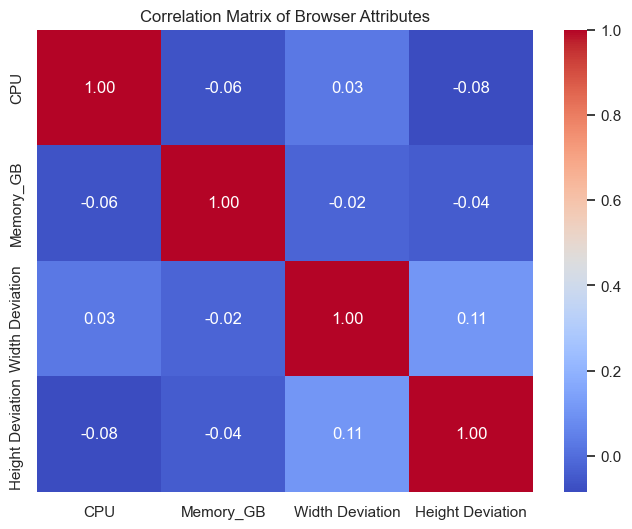

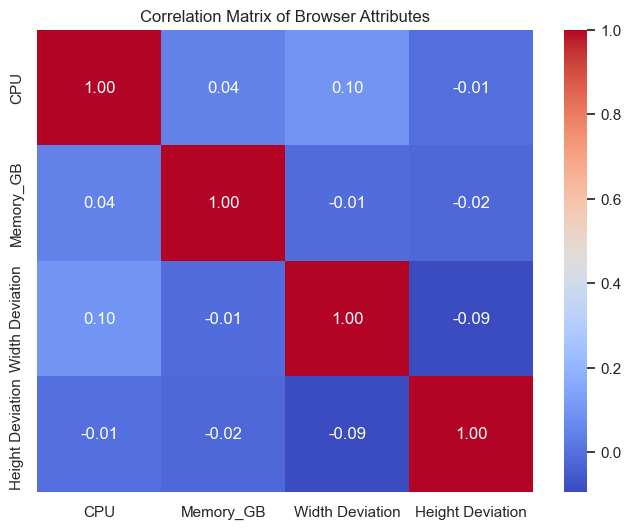

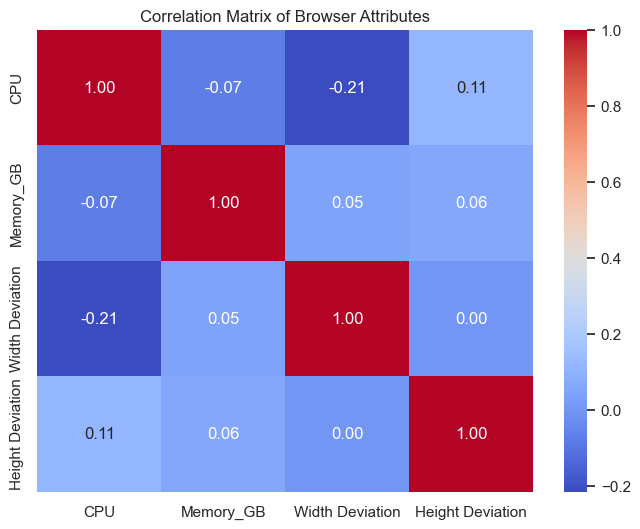

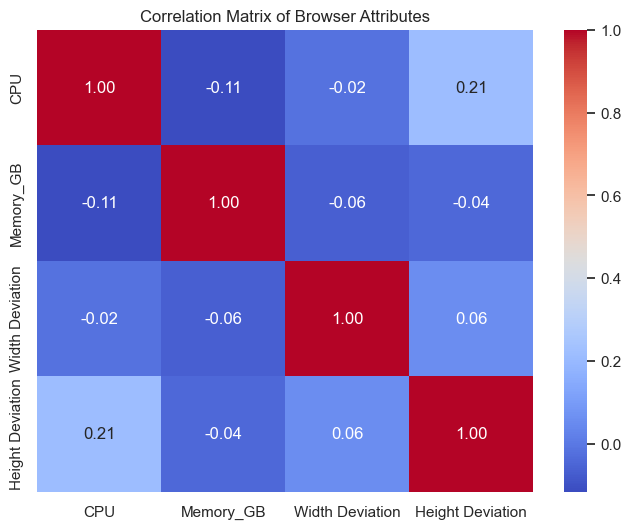

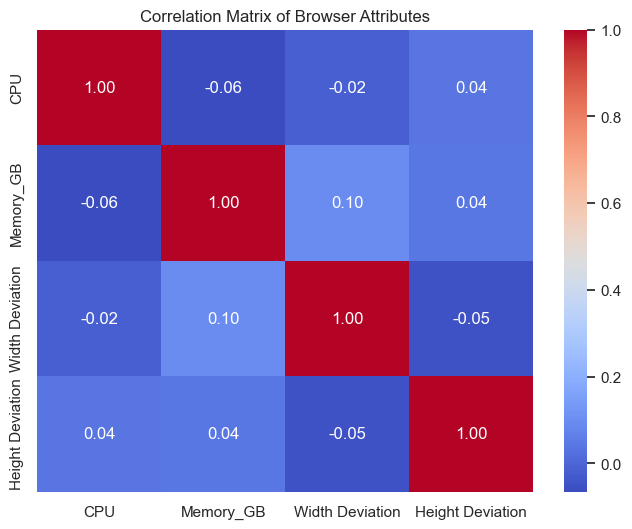

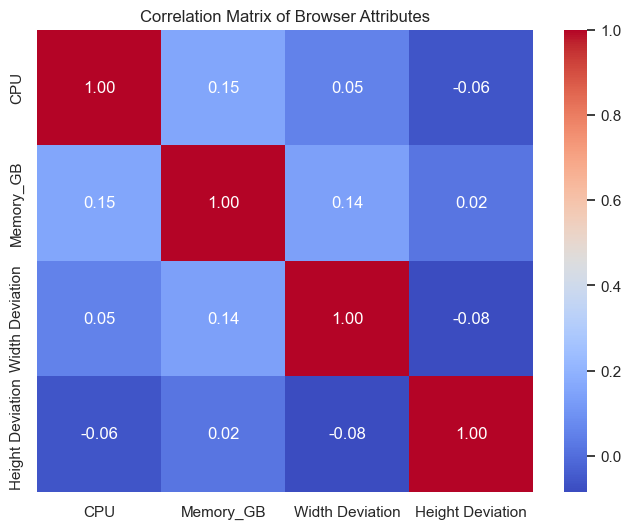

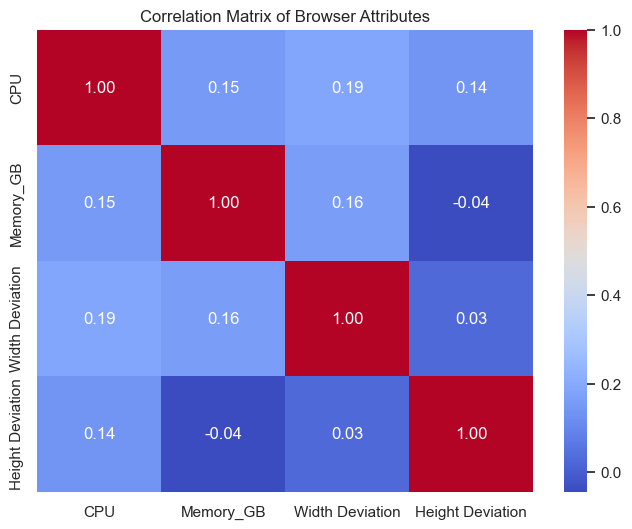

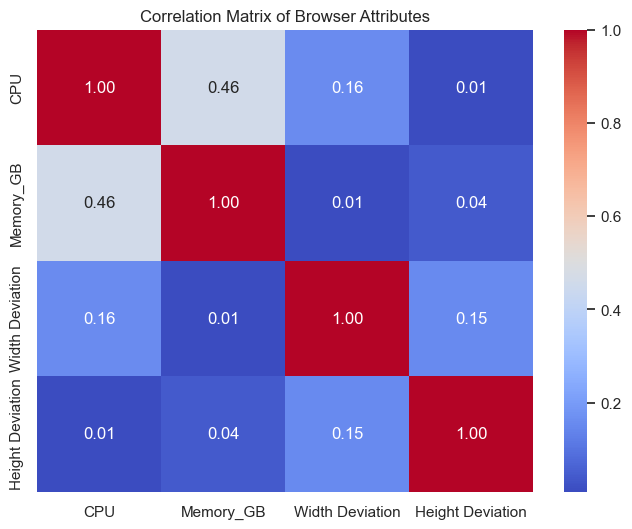

In [255]:
create_correlation_matrix4(pc_a_win10_strict)
create_correlation_matrix4(pc_a_win10_classic)
create_correlation_matrix4(pc_a_ubuntu_strict)
create_correlation_matrix4(pc_a_ubuntu_classic)
create_correlation_matrix4(pc_b_win11_strict)
create_correlation_matrix4(pc_b_win11_classic)
create_correlation_matrix4(pc_c_macos_strict)
create_correlation_matrix4(pc_c_macos_classic)



# Analysis of CPU cores

In [256]:
cpu_stats = get_stats('CPU')

print("CPU")
print(cpu_stats)

CPU
                           mean  median  range  var   max  min  std
PC A Win10 Brave Strict    5.11    5.00   6.00 3.94  8.00 2.00 1.98
PC A Win10 Brave Classic   2.98    3.00   2.00 0.72  4.00 2.00 0.85
PC A Ubuntu Brave Strict   4.79    5.00   6.00 3.36  8.00 2.00 1.83
PC A Ubuntu Brave Classic  2.96    3.00   2.00 0.61  4.00 2.00 0.78
PC B Win11 Brave Strict    5.00    5.00   6.00 4.21  8.00 2.00 2.05
PC B Win11 Brave Classic   4.93    5.00   6.00 3.68  8.00 2.00 1.92
PC C MacOS Brave Strict    5.10    5.00   6.00 4.37  8.00 2.00 2.09
PC C MacOS Brave Classic   6.83    7.00   9.00 8.49 11.00 2.00 2.91


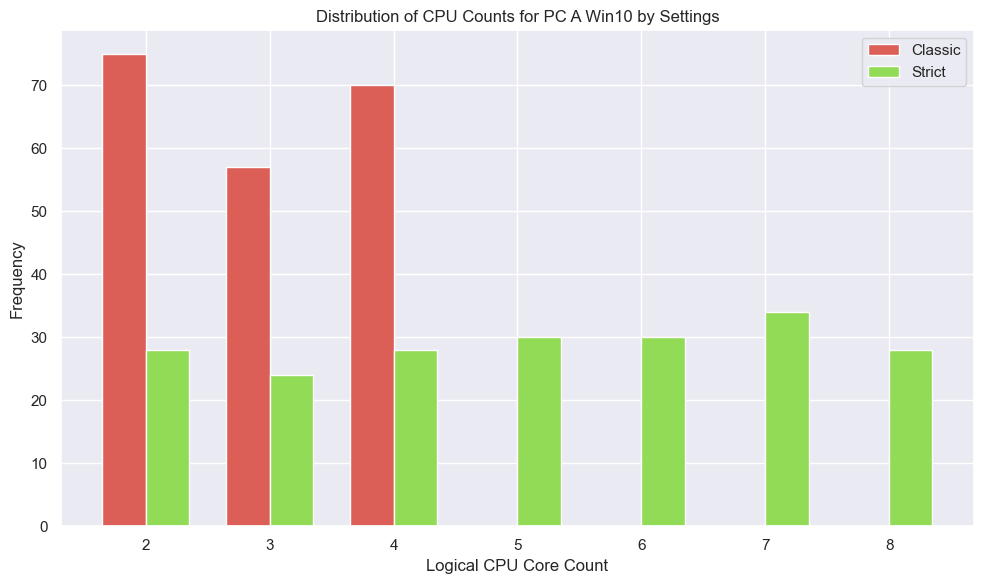

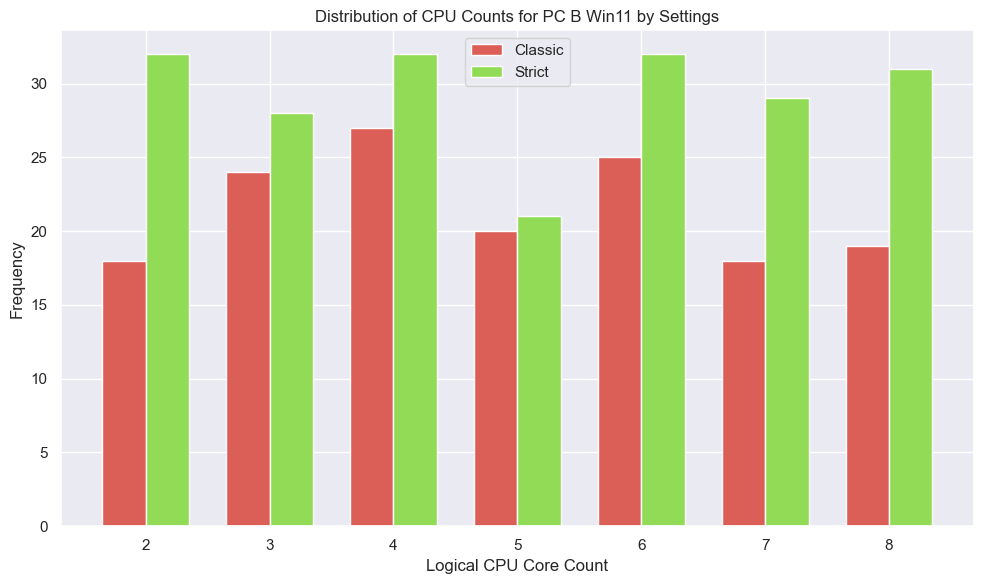

In [257]:
create_distribution_plot(pc_a_win10_classic, pc_a_win10_strict, 'Classic', 'Strict', 'Distribution of CPU Counts for PC A Win10 by Settings', 'Logical CPU Core Count', 'Frequency', 'CPU')
create_distribution_plot(pc_b_win11_classic, pc_b_win11_strict, 'Classic', 'Strict', 'Distribution of CPU Counts for PC B Win11 by Settings', 'Logical CPU Core Count', 'Frequency', 'CPU')

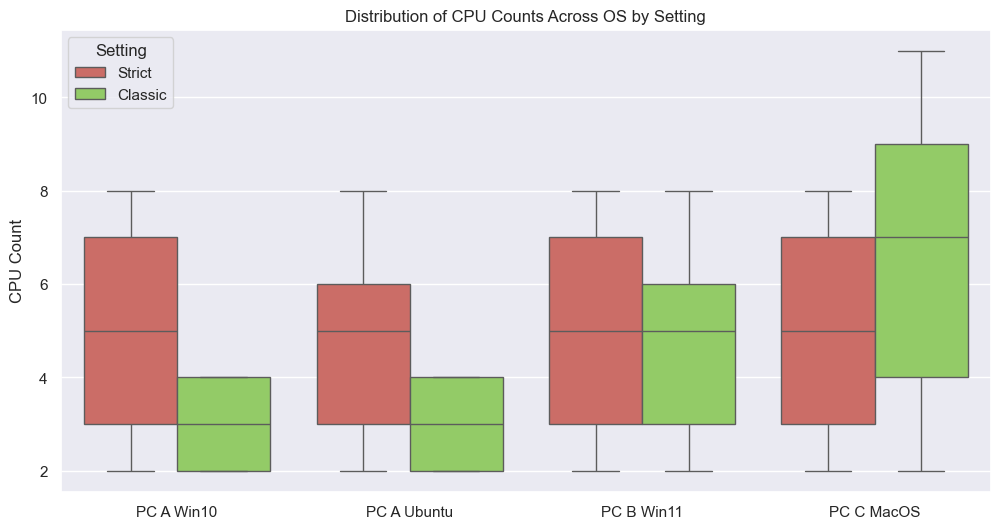

In [258]:
create_comparing_boxplot('CPU', 'Distribution of CPU Counts Across OS by Setting', '', 'CPU Count')

# Memory analysis

In [259]:
mem_stats = get_stats('Memory_GB')
print(mem_stats)

                           mean  median  range  var  max  min  std
PC A Win10 Brave Strict    2.78    2.00   7.75 8.08 8.00 0.25 2.84
PC A Win10 Brave Classic   3.37    2.00   7.50 8.25 8.00 0.50 2.87
PC A Ubuntu Brave Strict   2.69    2.00   7.75 8.14 8.00 0.25 2.85
PC A Ubuntu Brave Classic  3.11    2.00   7.50 6.86 8.00 0.50 2.62
PC B Win11 Brave Strict    2.64    1.00   7.75 7.43 8.00 0.25 2.73
PC B Win11 Brave Classic   3.10    2.00   7.50 7.43 8.00 0.50 2.73
PC C MacOS Brave Strict    2.69    2.00   7.75 7.32 8.00 0.25 2.71
PC C MacOS Brave Classic   3.04    2.00   7.50 7.24 8.00 0.50 2.69


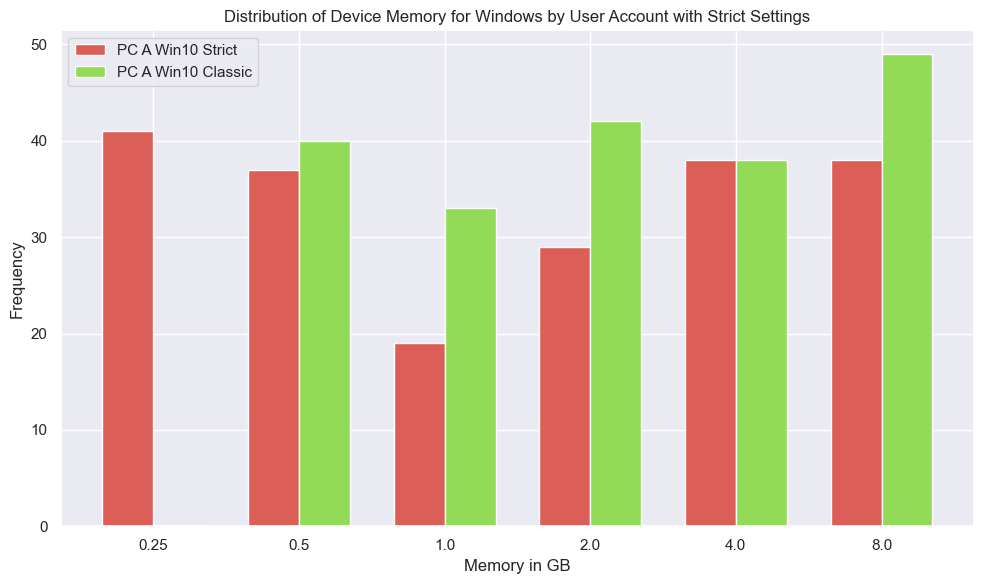

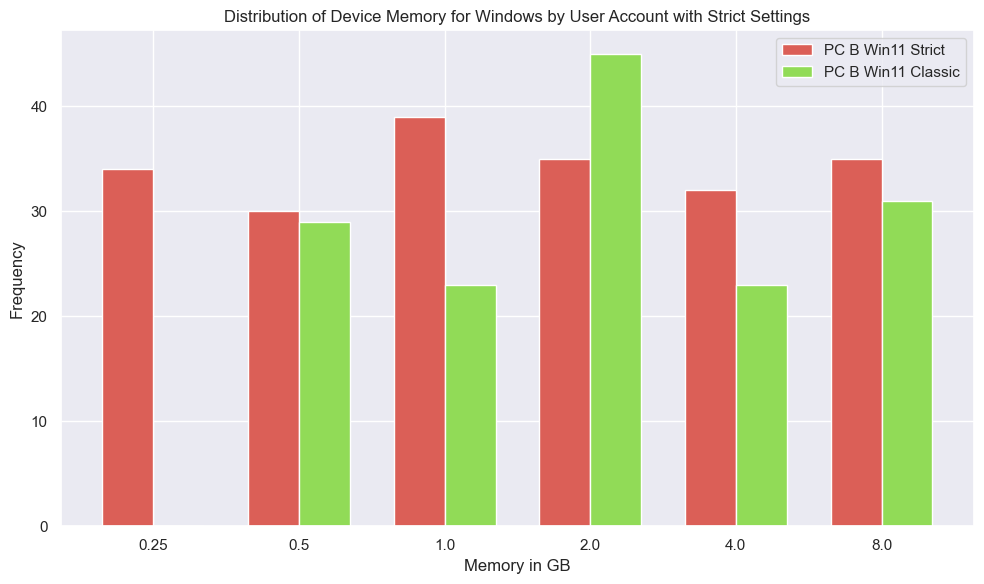

In [260]:
create_distribution_plot(pc_a_win10_strict, pc_a_win10_classic, 'PC A Win10 Strict', 'PC A Win10 Classic', 'Distribution of Device Memory for Windows by User Account with Strict Settings', 'Memory in GB', 'Frequency', 'Memory_GB')
create_distribution_plot(pc_b_win11_strict, pc_b_win11_classic, 'PC B Win11 Strict', 'PC B Win11 Classic', 'Distribution of Device Memory for Windows by User Account with Strict Settings', 'Memory in GB', 'Frequency', 'Memory_GB')

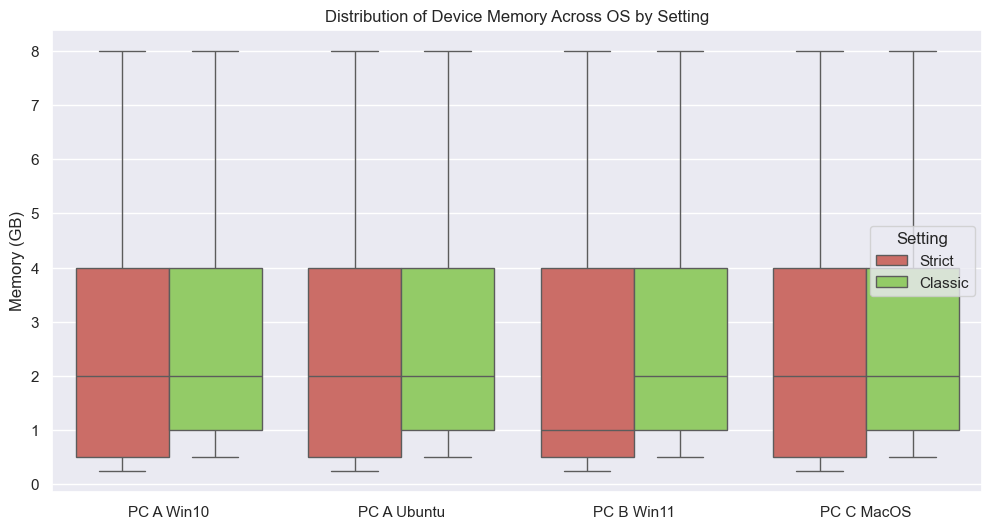

In [261]:
create_comparing_boxplot('Memory_GB', 'Distribution of Device Memory Across OS by Setting', '', 'Memory (GB)')

In [262]:
create_freq_table("Memory_GB")

,PC A Win10 Brave Strict,PC A Win10 Brave Classic,PC A Ubuntu Brave Strict,PC A Ubuntu Brave Classic,PC B Win11 Brave Strict,PC B Win11 Brave Classic,PC C MacOS Brave Strict,PC C MacOS Brave Classic
Memory_GB,,,,,,,,
0.25,41,0,16,0,34,0,15,0
0.50,37,40,25,14,30,29,17,21
1.00,19,33,8,23,39,23,15,17
2.00,29,42,18,21,35,45,20,24
4.00,38,38,14,23,32,23,17,19
8.00,38,49,19,18,35,31,17,19


# Deviation Analysis

In [263]:
create_freq_table("Width Deviation")

,PC A Win10 Brave Strict,PC A Win10 Brave Classic,PC A Ubuntu Brave Strict,PC A Ubuntu Brave Classic,PC B Win11 Brave Strict,PC B Win11 Brave Classic,PC C MacOS Brave Strict,PC C MacOS Brave Classic
Width Deviation,,,,,,,,
0,28,20,16,8,20,12,9,8
1,21,28,5,9,21,26,13,12
2,24,18,11,7,23,10,8,12
3,23,22,17,5,21,20,10,14
4,18,22,10,16,21,13,7,12
5,16,21,5,20,28,16,18,8
6,23,24,10,13,32,15,19,10
7,26,23,11,13,16,21,5,15
8,23,24,15,8,23,18,12,9


In [264]:
create_freq_table("Height Deviation")

,PC A Win10 Brave Strict,PC A Win10 Brave Classic,PC A Ubuntu Brave Strict,PC A Ubuntu Brave Classic,PC B Win11 Brave Strict,PC B Win11 Brave Classic,PC C MacOS Brave Strict,PC C MacOS Brave Classic
Height Deviation,,,,,,,,
0,27,22,16,13,22,16,16,14
1,25,30,14,14,37,15,10,8
2,22,27,10,18,24,22,11,11
3,21,21,14,8,19,19,16,5
4,31,28,10,7,15,10,10,12
5,26,31,13,11,23,13,10,14
6,30,18,8,12,28,20,9,12
7,9,16,10,7,22,17,10,10
8,11,9,5,9,15,19,9,14


In [265]:
width_stats = get_stats('Width Deviation')
print(width_stats)

                           mean  median  range  var  max  min  std
PC A Win10 Brave Strict    3.93    4.00   8.00 7.29 8.00 0.00 2.70
PC A Win10 Brave Classic   4.06    4.00   8.00 6.83 8.00 0.00 2.61
PC A Ubuntu Brave Strict   4.00    4.00   8.00 7.54 8.00 0.00 2.75
PC A Ubuntu Brave Classic  4.39    5.00   8.00 5.55 8.00 0.00 2.36
PC B Win11 Brave Strict    4.11    4.00   8.00 6.31 8.00 0.00 2.51
PC B Win11 Brave Classic   4.10    4.00   8.00 6.92 8.00 0.00 2.63
PC C MacOS Brave Strict    4.18    5.00   8.00 6.31 8.00 0.00 2.51
PC C MacOS Brave Classic   4.03    4.00   8.00 6.31 8.00 0.00 2.51


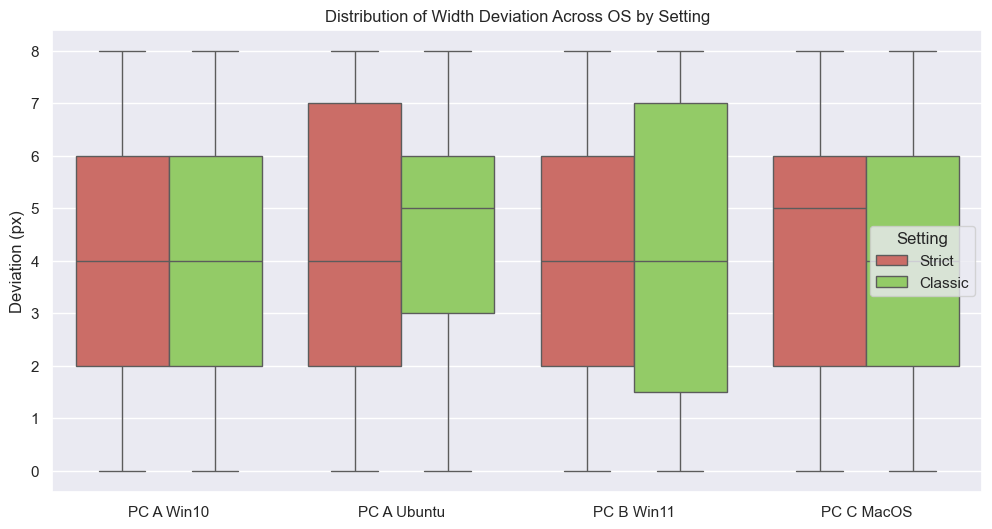

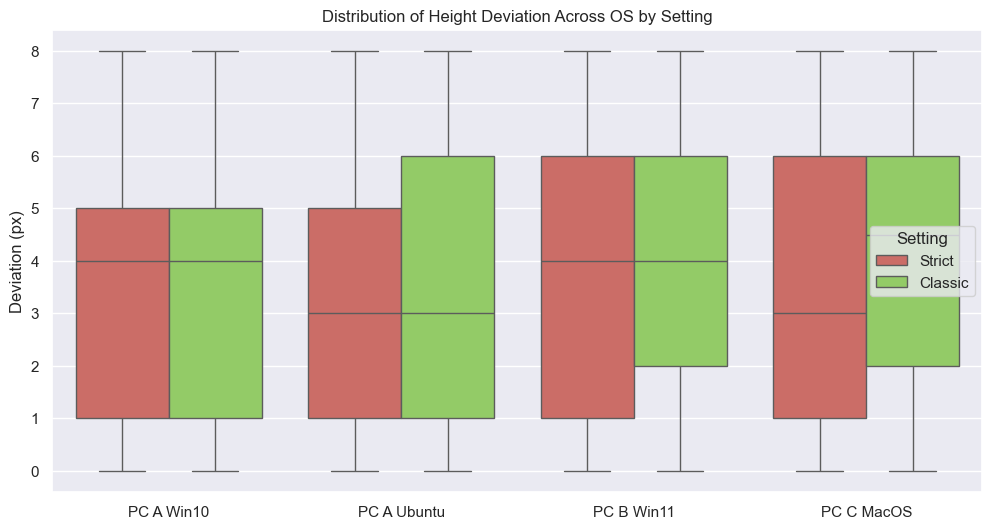

In [266]:
create_comparing_boxplot('Width Deviation', 'Distribution of Width Deviation Across OS by Setting', '', 'Deviation (px)')
create_comparing_boxplot('Height Deviation', 'Distribution of Height Deviation Across OS by Setting', '', 'Deviation (px)')

# Plugins analysis


In [267]:
plugins_df = pd.concat(
    [df[['Plugins']].assign(Source=key) for key, df in dataframes.items()],
    ignore_index=True
)

plugins_df['Plugins_Dict'] = plugins_df['Plugins'].apply(safe_string_to_dict)

In [268]:
unique_words = [
    "Brave",
    "Browser",
    "Chrome",
    "Chromium",
    "Display",
    "Document",
    "Format",
    "internal",
    "Microsoft",
    "Edge",
    "WebKit",
    "built-in",
    "JavaScript",
    "Online",
    "OpenSource",
    "PDF",
    "PS",
    "Plugin",
    "Portable",
    "Renderer",
    "Viewer",
    "Web",
    "and",
    "com.adobe.pdf",
    "doc",
    "document",
    "extension",
    "plug",
    "plug-in",
    "portable",
    "document",
    "format",
]

def find_known_plugins(dict):
    normal_words = 0
    for key, value in dict.items():
        for word in unique_words:
            if len(word) < 4:
                continue
            if word.lower() in key.lower():
                normal_words = normal_words + 1
                break
            elif word.lower() in value.lower():
                normal_words = normal_words + 1
                break
    return [normal_words, len(dict)-normal_words]

plugins_df['Plugins count'] = plugins_df['Plugins_Dict'].apply(find_known_plugins)

<Figure size 1400x800 with 0 Axes>

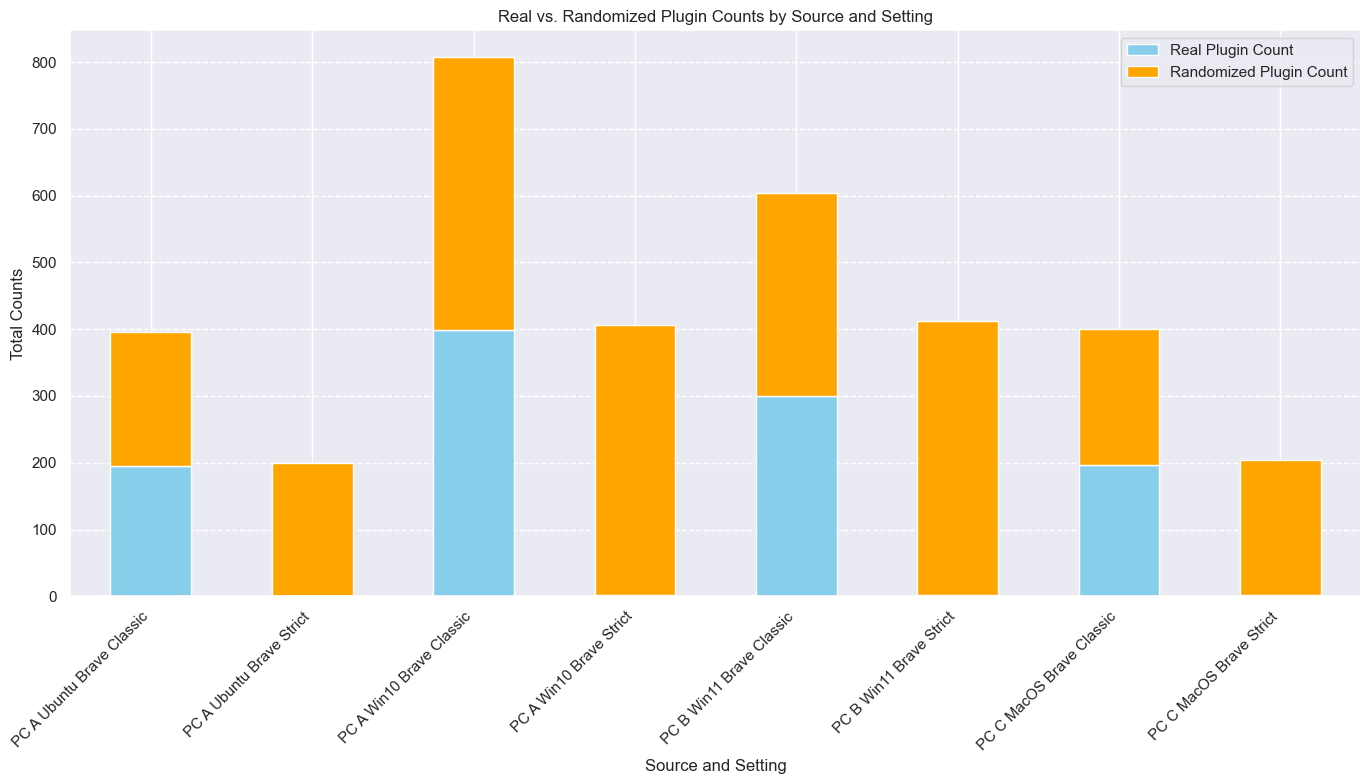

In [269]:
plugins_df[['Real Plugin Count', 'Randomized Plugin Count']] = pd.DataFrame(plugins_df['Plugins count'].tolist(), index=plugins_df.index)
source = plugins_df.groupby('Source')[['Real Plugin Count', 'Randomized Plugin Count']].sum()


plt.figure(figsize=(14, 8))
source.plot(kind='bar', stacked=True, color=['skyblue', 'orange'], figsize=(14, 8))

plt.title('Real vs. Randomized Plugin Counts by Source and Setting')
plt.ylabel('Total Counts')
plt.xlabel('Source and Setting')
plt.xticks(rotation=45, ha="right")
plt.legend(['Real Plugin Count', 'Randomized Plugin Count'])
plt.grid(axis='y', linestyle='--')

plt.tight_layout()

In [270]:
# Extract device type and setting from the 'Source' column if not already done
plugins_df['Device Type'] = plugins_df['Source'].str.extract('(Win|WinNB|Win2|WinNB2)')
plugins_df['Setting'] = plugins_df['Source'].apply(lambda x: 'Strict' if 'Strict' in x else 'Classic')

# Group by 'Device Type' and 'Setting' to calculate average real and randomized plugin counts
average_counts_per_device_setting = plugins_df.groupby(['Source'])[['Real Plugin Count', 'Randomized Plugin Count']].mean().reset_index()

average_counts_per_device_setting

,Source,Real Plugin Count,Randomized Plugin Count
0,PC A Ubuntu Brave Classic,1.97,2.03
1,PC A Ubuntu Brave Strict,0.00,2.00
2,PC A Win10 Brave Classic,1.98,2.02
3,PC A Win10 Brave Strict,0.01,2.00
4,PC B Win11 Brave Classic,1.99,2.01
5,PC B Win11 Brave Strict,0.01,2.00
6,PC C MacOS Brave Classic,1.97,2.03
7,PC C MacOS Brave Strict,0.02,2.00


<Figure size 1400x800 with 0 Axes>

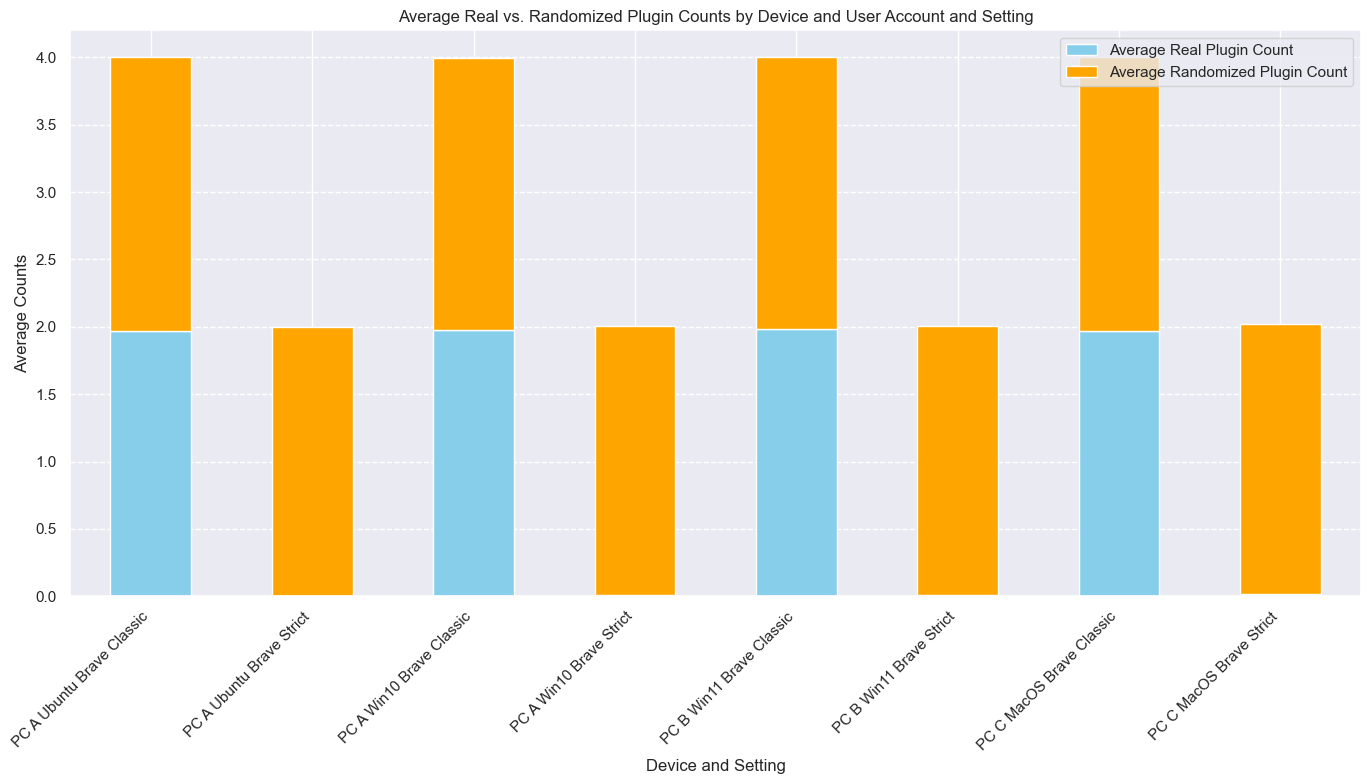

In [271]:
average_counts_per_device_setting.reset_index(inplace=True)

average_counts_for_plotting = average_counts_per_device_setting.set_index('Source')

plt.figure(figsize=(14, 8))
average_counts_for_plotting[['Real Plugin Count', 'Randomized Plugin Count']].plot(kind='bar', stacked=True, color=['skyblue', 'orange'], figsize=(14, 8))

plt.title('Average Real vs. Randomized Plugin Counts by Device and User Account and Setting')
plt.ylabel('Average Counts')
plt.xlabel('Device and Setting')
plt.xticks(rotation=45, ha="right")
plt.legend(['Average Real Plugin Count', 'Average Randomized Plugin Count'])
plt.grid(axis='y', linestyle='--')

plt.tight_layout()

plt.show()